In [1]:
%cd /Users/lchevalier/Dropbox/Project1_N4526/sextractor

/Users/lchevalier/Dropbox/Project1_N4526/sextractor


In [2]:
import numpy as np
from numpy import append
from astropy.io import fits
from astropy.io import ascii
import matplotlib.pyplot as plt
import scipy as sc
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from sklearn import mixture
#from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.mlab as mlab
from cycler import cycler
from numpy import append
%matplotlib inline

In [3]:
def AB_mag(mag,dist):
    if dist<10**5:
        dist=dist*(10**6)
        #print 'Distance was not entered in pc. And was now converted!!'
    else:
        pass#print ''
    AB= mag - (5*np.log10(dist/10))
    
    return AB

def best_fit(X, Y):
    
    xbar = np.mean(X)#sum(X)/len(X)
    ybar = np.mean(Y)#sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

def diviation(sources):
    x=sources
    lenght= len(sources)
    mean=np.mean(sources)
    standart_dev=(sum((x-mean)**2)/lenght)**0.5
    variance=(sum((x-mean)**2)/lenght)
    
    return standart_dev,variance

def RMS(sources):
    mag= sources
    rms=np.sqrt(np.mean(mag**2))
    
    return rms

def FWHM(sources):
    fwhm=2*np.sqrt(2*np.log(2)*diviation(sources)[0])
    
    return fwhm

def Pritchet_f (mag, mag_0, a ):
    f=0.5 *(1-(a*(mag-mag_0))/(1+(a**2)*(mag-mag_0)**2)**0.5)
    
    return f

def density(Dist):
    dist= np.arange(1,max(Dist),1)
    bins=[]
    #annuli= np.pi*dist**2
    for i in dist:
       bins.append( len(Dist[Dist <= i]))
    return (bins)

def gaussian(x, mu, sig, norm=1):
    return (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))*(norm)#/(np.sqrt(np.pi*2)*sig))

def fit_mixture(data, ncomp=2, doplot=False, bins=200):# only fits up to 4 comp at the moment need to change colours o fit more
    clf = mixture.GMM(n_components=ncomp, covariance_type='full', n_iter=100, n_init=10) # different types of covariance ???
    clf.fit(data)
    ml = clf.means_
    wl = clf.weights_
    cl = clf.covars_
    ms = [m[0] for m in ml]
    cs = [np.sqrt(c[0][0]) for c in cl]
    ws = [w for w in wl]
    colours= ['b', 'r', 'g', 'y']
    col =[]
    #print col
    for i in np.arange(0,ncomp,1):
        col.append(colours[i])
    if doplot == True:
        histo = plt.hist(data, bins, normed=True, color='black', histtype='step')
        #plt.rc('axes', prop_cycle=(cycler('color', ['b', 'r', 'g', 'y'])))
        #ax.set_prop_cycle(cycler('color', ['b', 'r', 'g', 'y']))
        for w, m, c, cl in zip(ws, ms, cs, col):
            plt.plot(histo[1],w*mlab.normpdf(histo[1],m,c), linewidth=3, color = cl)
    return ms, cs, ws #where ms= means cs=covaiance and ws = weights ?!

# 0.3<g-r<0.9
# 0.5<g-i<1.3

cut_gr = [0.3,0.9,0.1,0.1]
cut_gi = [0.5,1.3,0.1,0.1]
cut_ri= [0,0.6]

def Z_gr(gr_range):#all of these need errors on them !! Need a way to incorperate mean errors for g-i and g-r !!
    a,b,a_err,b_err = gr_range
    if (a<b)&(a<0.55)&(b>0.55):
        Zmin= 12.23*a-8.04
        Zmin_err = abs(((2.10/12.23)+(a_err/a))*Zmin+1.01)
        Zmax=5.72*b-4.47
        Zmax_err= abs(((0.20/5.72)+(b_err/b))*Zmax+0.11)
    elif (a>b)&(b<0.55)&(a>0.55):
        Zmin= 12.23*b-8.04
        Zmin_err = abs(((2.10/12.23)+(b_err/b))*Zmin+1.01)
        Zmax=5.72*a-4.47
        Zmax_err= abs(((0.20/5.72)+(a_err/a))*Zmax+0.11)
        
    else: 
        #print 'help'

        
        return Zmin,Zmax, Zmin_err, Zmax_err    

def Z_gi(gi_range):
    a,b,a_err,b_err = gi_range
    if (a<b)&(a<0.77)&(b>0.77):
        Zmin= 7.46*a-7.09
        Zmin_err = abs(((1.28/7.46)+(a_err/a))*Zmin+1.01)
        Zmax=3.49*b-4.03
        Zmax_err= abs(((0.12/3.49)+(b_err/b))*Zmax+0.11)
    elif (a>b)&(b<0.55)&(a>0.55):
        Zmin= 7.46*b-7.09
        Zmin_err = abs(((1.28/7.46)+(b_err/b))*Zmin+1.01)
        Zmax=3.49*a-4.03
        Zmax_err= abs(((0.12/3.49)+(a_err/a))*Zmax+0.11)
        
    else: 
        #print ('help')

        
            return  Zmin,Zmax, Zmin_err, Zmax_err    
    



In [4]:
filename='N4526_full_candidates.fits'
filename2='N4526_full_candidates_no_lim.fits'
hdulist=fits.open(filename)
hdulist2=fits.open(filename2)
Candidates = hdulist[1].data
Subaru_comp = hdulist2[1].data
Gmag='Gmag'
Imag='Imag'
Rmag='Rmag'
GDist=Subaru_comp['GDist']

f = open('peakprop_no_outer_limit_full.out', 'r') # thid file has to be altered so the header with the means is taken out!!
P1=[]#probability of read
P2=[]#probability of blue
for line in f:
    line = line.strip()
    columns = line.split()
    prob = float(columns[0])
    j = float(columns[1])
    i = float(columns[2])
    P1.append(prob)
    P2.append(j)
    print(prob, j, i)

    
f = open('peakprob_full_candidates.out', 'r') # thid file has to be altered so the header with the means is taken out!!
red=[]#probability of read
blue=[]#probability of blue
for line in f:
    line = line.strip()
    columns = line.split()
    prob = float(columns[0])
    j = float(columns[1])
    i = float(columns[2])
    red.append(prob)
    blue.append(j)
    print(prob, j, i)
    
    
print len(P1)
P1= np.array(P1)
P2= np.array(P2)

red=np.array(red)
blue=np.array(blue)

(0.0, 1.0, 0.523197)
(0.277, 0.723, 0.901155)
(0.907, 0.093, 1.05747)
(0.791, 0.209, 1.00978)
(0.858, 0.142, 1.03285)
(0.02, 0.98, 0.773243)
(0.0, 1.0, 0.618729)
(0.738, 0.262, 0.995182)
(0.0, 1.0, 0.523968)
(0.999, 0.001, 1.29551)
(0.74, 0.26, 0.995872)
(0.809, 0.191, 1.0153)
(0.995, 0.005, 1.21902)
(0.0, 1.0, 0.606146)
(0.003, 0.997, 0.695881)
(0.972, 0.028, 1.12435)
(0.081, 0.919, 0.835735)
(0.955, 0.045, 1.09726)
(0.009, 0.991, 0.739262)
(0.0, 1.0, 0.509155)
(0.0, 1.0, 0.546385)
(0.948, 0.052, 1.0897)
(0.02, 0.98, 0.773026)
(0.466, 0.534, 0.939146)
(0.033, 0.967, 0.794767)
(0.255, 0.745, 0.896019)
(0.877, 0.123, 1.04127)
(0.997, 0.003, 1.25859)
(0.553, 0.447, 0.955616)
(0.978, 0.022, 1.13753)
(0.893, 0.107, 1.04905)
(0.233, 0.767, 0.890665)
(0.992, 0.008, 1.19145)
(0.0, 1.0, 0.500433)
(0.858, 0.142, 1.03284)
(0.0, 1.0, 0.483894)
(0.805, 0.195, 1.01393)
(0.311, 0.689, 0.908583)
(0.231, 0.769, 0.890051)
(0.365, 0.635, 0.919691)
(0.092, 0.908, 0.841499)
(0.007, 0.993, 0.731262)
(0.016

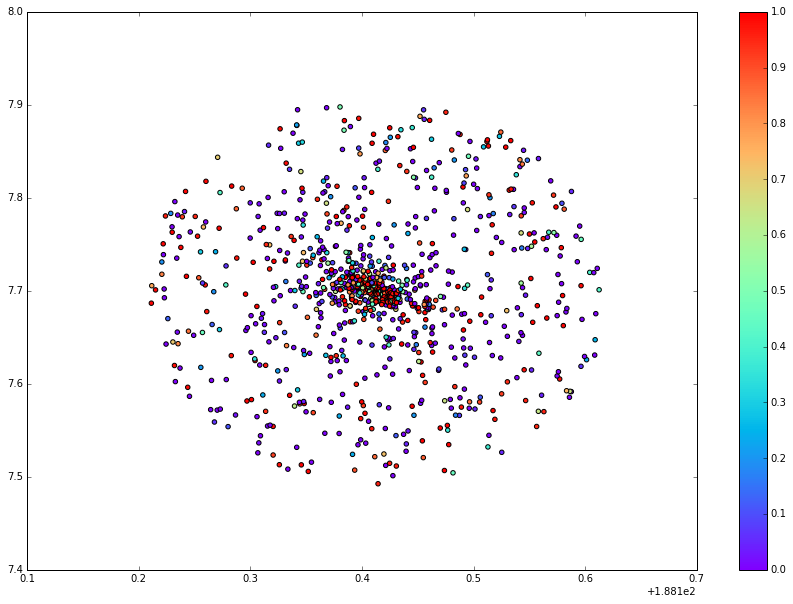

In [6]:
plt.figure(figsize=(15,10))
plt.scatter(Candidates['RA'], Candidates['Dec'], c=red, cmap='rainbow')
plt.colorbar()

plt.show()

In [8]:
DBins=np.array([0,0.75,1,1.5,3,6,8,12,14,16,17])
Area = (DBins**2) *np.pi
Rad=[]
offset=[]
#print np.arange(1,len(Area),1)
for i in np.arange(1,len(Area),1): #loosing abin in the process .... 
    offset.append((DBins[i]-DBins[i-1])/2)
    
    Rad.append(Area[i]-Area[i-1])
print len(Rad)

Pritt = np.round(1+1-Pritchet_f((DBins[:-1]+offset),0.5,-0.5),2)
print Pritt
plt.figure()
n,bins,patches = plt.hist(GDist[Subaru_comp[Imag]>=23]/60, bins=DBins)#, weights=Pritt[Subaru_comp[Imag]>=23])
nr,rbins,patchesr = plt.hist((GDist[Subaru_comp[Imag]>=23]/60),weights = P1[Subaru_comp[Imag]>=23], bins=DBins)
nb,bbins,patchesb = plt.hist((GDist[Subaru_comp[Imag]>=23]/60),weights = P2[Subaru_comp[Imag]>=23], bins=DBins)



print n[6], np.sqrt(n[6]*Pritt[6]), Rad[6]


frac_red = nr/n
frac_blue = nb/n

error_sd = np.sqrt(n*Pritt)/Rad
error_sd_r = np.sqrt(nr*(Pritt*frac_red))/Rad
error_sd_b = np.sqrt(nb*(Pritt*frac_blue))/Rad
print error_sd[6]
plt.close()

10
[ 1.53  1.41  1.32  1.17  1.05  1.02  1.01  1.01  1.    1.  ]
95.0 9.795407087 251.327412287
0.0389746864373


In [220]:
for i in np.arange(0,len(n)): # check where effective radius is approximately
    np.sum(n[:i])/np.sum(n)
    if np.round(np.sum(n[:i])/np.sum(n),1) ==0.5:
        print i-1

5


In [227]:
plt.figure()
more_bins = np.arange(0,np.max(DBins),0.16)
Ne,n,m = plt.hist(GDist[Subaru_comp[Imag]>=23]/60,bins=more_bins,histtype='step',cumulative=True)
#Ne=np.cumsum(Ne)
plt.close()
print Ne
print np.where(np.round((Ne/len(GDist[Subaru_comp[Imag]>=23])),2) == 0.5)

Re = more_bins[np.where(np.round((Ne/len(GDist[Subaru_comp[Imag]>=23])),2) == 0.5)]     
index = 0.5
bn = 1.9992*index - 0.3271
bg = 1.6

[   0.    5.   10.   27.   40.   50.   58.   72.   83.   91.   96.  106.
  111.  120.  124.  129.  133.  135.  143.  145.  146.  151.  152.  154.
  158.  161.  162.  166.  171.  176.  178.  179.  181.  190.  194.  196.
  199.  203.  207.  211.  212.  215.  217.  220.  225.  228.  232.  237.
  242.  246.  248.  250.  251.  253.  261.  265.  270.  274.  278.  281.
  283.  286.  292.  296.  301.  306.  309.  310.  313.  316.  319.  325.
  335.  339.  341.  352.  356.  361.  365.  367.  372.  373.  381.  382.
  387.  393.  401.  409.  410.  413.  419.  425.  431.  438.  444.  453.
  456.  463.  468.  472.  480.  481.  486.  494.  501.  508.]
(array([61]),)


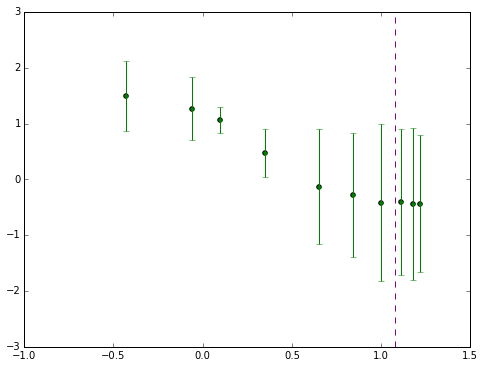

In [211]:
plt.figure(figsize=(8,6))
plt.scatter(np.log10(DBins[:-1]+offset),np.log10(n*Pritt/Rad), c='g')
#plt.scatter(np.log10(DBins[:-1]+offset),np.log10(nr*(Pritt*frac_red)/Rad), c='r')
#plt.scatter(np.log10(DBins[:-1]+offset),np.log10(nb*(Pritt*frac_blue)/Rad), c='b')
plt.axvline(np.log10(750/60), ls ='--', c='purple')


plt.errorbar(np.log10(DBins[:-1]+offset),np.log10(n*(Pritt)/Rad),xerr=0, yerr=np.log10(error_sd), color='green', fmt='.')
#plt.errorbar(np.log10(DBins[:-1]+offset),np.log10(nr*(Pritt*frac_red)/Rad),xerr=0, yerr=np.log10(error_sd_r), color='red', fmt='.')
#plt.errorbar(np.log10(DBins[:-1]+offset),np.log10(nb*(Pritt*frac_blue)/Rad),xerr=0, yerr=np.log10(error_sd_b), color='blue', fmt='.')
plt.show()

In [219]:
np.arange(0,11,1)[:6]

array([0, 1, 2, 3, 4, 5])